In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, done, _, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            done = True

        return state, reward, done, info


env = MyWrapper()

env.reset()

array([ 0.04291243,  0.0479058 , -0.01014704,  0.02571197], dtype=float32)

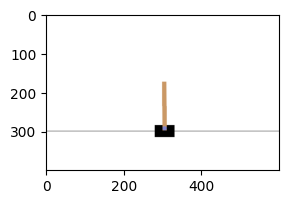

In [2]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [3]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state = env.reset()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', done)


test_env()

env.observation_space= Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
env.action_space= Discrete(2)
state= [ 0.04587445 -0.02671207  0.03698547  0.020224  ]
action= 1
next_state= [ 0.04534021  0.1678605   0.03738995 -0.260564  ]
reward= 1.0
done= False


In [4]:
import torch

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

#经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
)

#把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=2, bias=True)
 ))

In [5]:
import random


#得到一个动作
def get_action(state):
    if random.random() < 0.01:
        return random.choice([0, 1])

    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 4)

    return model(state).argmax().item()


get_action([0.0013847, -0.01194451, 0.04260966, 0.00688801])

1

In [6]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state = env.reset()

        #玩到游戏结束为止
        over = False
        while not over:
            #根据当前状态得到一个动作
            action = get_action(state)

            #执行动作,得到反馈
            next_state, reward, over, _ = env.step(action)

            #记录数据样本
            datas.append((state, action, reward, next_state, over))

            #更新游戏状态,开始下一个动作
            state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 1_0000:
        datas.pop(0)


update_data()

len(datas)

200

In [7]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 4]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    #[b, 4]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 4)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

/tmp/ipykernel_41739/2021397730.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 4)


(tensor([[ 6.9080e-03,  8.3188e-01, -1.0945e-01, -1.2396e+00],
         [ 1.1659e-01,  5.7994e-01, -1.6258e-01, -1.0571e+00],
         [-2.2631e-02,  5.8258e-01,  2.7247e-02, -8.3719e-01],
         [ 9.0803e-02,  7.6052e-01, -1.7939e-01, -1.3275e+00],
         [-2.2402e-02,  8.2984e-01, -6.7245e-02, -1.1907e+00],
         [-4.4527e-02,  1.8322e-01,  3.0115e-02, -2.8778e-01],
         [ 9.5200e-02,  8.0116e-01, -1.3847e-01, -1.2238e+00],
         [ 4.6056e-03,  2.0080e-01,  4.5945e-02, -3.0775e-01],
         [ 1.2549e-01,  7.8756e-01, -1.9666e-01, -1.3698e+00],
         [ 1.3037e-01,  7.9307e-01, -1.6008e-01, -1.2802e+00],
         [ 1.0429e-01,  7.3912e-01, -1.6689e-01, -1.3640e+00],
         [ 4.0308e-02,  7.8627e-01, -4.9682e-02, -1.1381e+00],
         [ 1.3519e-01,  6.3556e-01, -9.7604e-02, -8.5991e-01],
         [ 1.0113e-01,  7.7309e-01, -1.3650e-01, -1.3041e+00],
         [ 1.1122e-01,  6.0807e-01, -1.6295e-01, -9.7753e-01],
         [-4.8710e-02,  2.4288e-01, -3.2508e-02, -2.756

In [8]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 4] -> [b, 2]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 2] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action).shape

torch.Size([64, 1])

In [9]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 4] -> [b, 2]
    with torch.no_grad():
        target = next_model(next_state)

    #取所有动作中分数最大的
    #[b, 2] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over).shape

torch.Size([64, 1])

In [10]:
from IPython import display


def test(play=False):
    state = env.reset()
    reward_sum = 0
    over = False
    while not over:
        action = get_action(state)
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

12.8

In [11]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(500):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 10 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 50 == 0:
            print(epoch, len(datas), sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/4.DQN_CartPole')


#train()

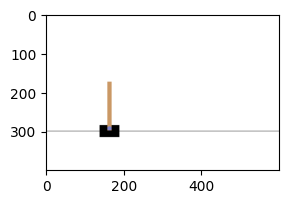

200.0

In [12]:
model = torch.load('save/4.DQN_CartPole')

test(play=True)